# Following tutorial from tensorflow

https://www.tensorflow.org/text/tutorials/nmt_with_attention

This tutorial trains a sequence to sequence (seq2seq) model for Spanish to English translation. This is supposed to be a beginner friendly tutorial, but for new people like myself, it is not completely intuitive.

The most important part of this tutorial I think is to setup the data pipeline. Many of the basic RNN/Transformer implementations I've seen taken in large chunks of text instead of Q/A type data (Kaparthys examples (from his [tutorials on youtube](https://www.youtube.com/watch?v=kCc8FmEb1nY&pp=ygUVa2FwYXJ0aHkgdHJhbnNmb3JtZXJz) or generally [his github](https://github.com/karpathy)) generally do this method - and so does tf's [Generate Text with RNN tutorial](https://www.tensorflow.org/text/tutorials/text_generation), which is based off Kaparthys work). Perhaps this is the correct way to go - following how tools like GPT are built by starting with large chunks of text like this, then fine tuning them for question answering. That's not completely intuitive to me though, so I am going ot try this method. This example is all about english to spanish translation, which I expect will probably have similar IO to Q/A.


# My implementation

I'm using the dataset generated by GPT, which contains ~113k questions and answers about SUNY Brockport. Elsewhere in this repo I published this dataset to hugginface to make it more accessible. For this notebook, I'm using that dataset from hugginface.

---

# Specifically this first iteration

I'm using only a small portion of the dataset (using the filtererd urls from the semantic search cleaning). This subset only contains 7k question answer pairs, which allows engineering to be sped up for testing purposes.

In [3]:
# I need to make a tf.data pipeline. I have a huggingface dataset, so I need to convert it somehow.
# Huggingface has tools built in to convert to tf.data, but I don't think they're exactly what I want.
# I think I might just try and breakdown the huggingface dataset to standard python objects to convert it all.

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # stop showing tensorflow logs...

from datasets import load_dataset
import tensorflow as tf
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

dataset_name = "msaad02/formatted-ss-cleaned-brockport-qa"
dataset = load_dataset(dataset_name, split="train")

dataset = dataset.to_dict()['text']
dataset[0:5]

['Below is an inquiery related to SUNY Brockport - from academics, admissions, and faculty support to student life. Prioritize accuracy and brevity."\n\n### Instruction:\nWhat limitations are there for non-matriculated students if they choose to enroll at a later date?\n\n### Response:\nIf non-matriculated students choose to enroll at a later date, they are subject to all changes in the course catalog.',
 'Below is an inquiery related to SUNY Brockport - from academics, admissions, and faculty support to student life. Prioritize accuracy and brevity."\n\n### Instruction:\nWhere can I find more information about scholarships and financial aid?\n\n### Response:\nYou can find more information about scholarships and financial aid by visiting the college website or contacting the college\'s financial aid office.',
 'Below is an inquiery related to SUNY Brockport - from academics, admissions, and faculty support to student life. Prioritize accuracy and brevity."\n\n### Instruction:\nWhat res

### Formatting

This dataset was built for the fine-tuning step. Perhaps I should change this such that the questions and answers are in separate columns, and then put it all together only in the notebook for fine-tuning. It should be simple enough to work with like this though, so for now this step is just going to split it into QA pairs.

In [4]:
def split_input_output(s):
    """
    Splits a string into a question and answer pair
    """
    output_split = s.split('\n\n### Response:\n')
    input_split = output_split[0].split('### Instruction:\n')[1]
    return input_split, output_split[1]

# Map above function over the list of questions, and create a list of questions and answers separately
context_raw, target_raw = [list(t) for t in zip(*[split_input_output(string) for string in dataset])]

# NOTE: Chosing to follow the naming conventions from the tutorial, for reference then:
# CONTEXT refers to QUESTIONS, and TARGET refers to ANSWERS

# "Raw" is used since currently the data is in string format, and needs to be standardized and vectorized

In [5]:
# Example
print(context_raw[-1])
print(target_raw[-1])

How can current students access their university email?
Current students can access their university email through the Webmail quicklink. It provides a secure platform for students to manage their university email accounts and communicate with faculty, staff, and peers.


# Creating a tf.data dataset

Now my data matches the format of the Spanish-to-English example in the tutorial, so I can use the same code to create a tf.data dataset.

In [6]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

is_train_mask = np.random.uniform(size=(len(target_raw),)) < 0.8

train_context = np.array(context_raw)[is_train_mask]
train_target = np.array(target_raw)[is_train_mask]

val_context = np.array(context_raw)[~is_train_mask]
val_target = np.array(target_raw)[~is_train_mask]

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_context, train_target))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((val_context, val_target))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [7]:
# Check to see it worked
for example_context_strings, example_target_strings in train_raw.take(1):
    print(example_context_strings[:5])
    print()
    print(example_target_strings[:5])
    break

tf.Tensor(
[b'Who can I contact for more information about the application process at SUNY Brockport?'
 b'What majors are offered in the College of Arts and Sciences at SUNY Brockport?'
 b'What specialized programs are offered at SUNY Brockport?'
 b"Which states' flagship universities are eligible for the tuition match program?"
 b'Are there IT support services available for students at SUNY Brockport?'], shape=(5,), dtype=string)

tf.Tensor(
[b'You can contact the Office of Undergraduate Admissions at (585) 395-2211 for more information.'
 b'Some of the majors offered in the College of Arts and Sciences at SUNY Brockport include Biology, Chemistry, English (Creative Writing and Literature), History, Mathematics, and Psychology.'
 b'SUNY Brockport offers various specialized programs, which can be found on the college website.'
 b'The states eligible for the flagship tuition match program at SUNY Brockport are Connecticut, Pennsylvania, New Jersey, Massachusetts, Vermont, New Hampshire,

# Text Standardization

The text vectorization method from keras will take care of a lot of this, but this is an additional step with some specifics to Spanish, but also adds special tokens for the tokenizer.

In [8]:
def tf_lower_and_split_punct(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

In [9]:
MAX_VOCAB_SIZE = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=MAX_VOCAB_SIZE,
    ragged=True
)

In [12]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:8]

['', '[UNK]', '[START]', '[END]', '?', 'the', 'what', 'brockport']

In [13]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=MAX_VOCAB_SIZE,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:8]

['', '[UNK]', ',', '.', 'the', '[START]', '[END]', 'and']

In [14]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 40, 13, 15, 36, 9, 63, 22, 32, 5, 106, 97, 12, 8, 7, 4, 3],
 [2, 6, 59, 11, 56, 19, 5, 51, 14, 69, 18, 149, 12, 8, 7, 4, 3],
 [2, 6, 385, 37, 11, 56, 12, 8, 7, 4, 3]]>

In [15]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] who can i contact for more information about the application process at suny brockport ? [END]'

Text(0.5, 1.0, 'Mask')

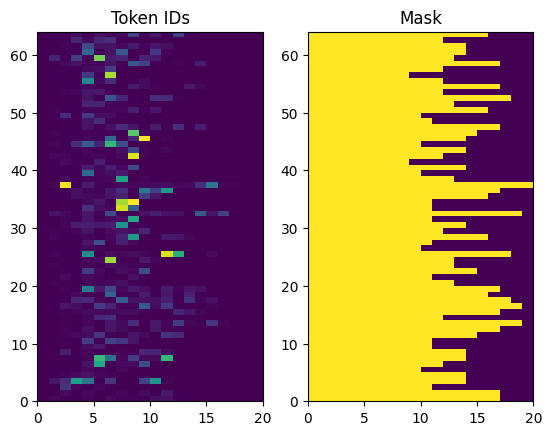

In [16]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

# Process The Dataset

*DESCRIPTION TAKEN DIRECTLY FROM THE TENSORFLOW TUTORIAL*

The process_text function below converts the Datasets of strings, into 0-padded tensors of token IDs. It also converts from a (context, target) pair to an ((context, target_in), target_out) pair for training with keras.Model.fit. Keras expects (inputs, labels) pairs, the inputs are the (context, target_in) and the labels are target_out. The difference between target_in and target_out is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [17]:
def process_text(context, target):
    context = context_text_processor(context).to_tensor()
    target = target_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [18]:
# Here is the first sequence of each, from the first batch:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy())

[   2   17   13   16  107   26 1344  539 2504    4]

[  5  16  13 893 213  52 609   1 128  10]
[ 16  13 893 213  52 609   1 128  10 128]


In [21]:
## FROM TUTORIAL
# This tutorial uses a lot of low level API's where it's easy to get shapes wrong. 
# This class is used to check shapes throughout the tutorial.

#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

# Encoder/Decoder Model

Just following tutorial at this point, I'll go back to learn it all once (and if) I get it working.

In [22]:
UNITS = 256

class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super(Encoder, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.units = units

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                                    mask_zero=True)

        # The RNN layer processes those vectors sequentially.
        self.rnn = tf.keras.layers.Bidirectional(
            merge_mode='sum',
            layer=tf.keras.layers.GRU(units,
                                # Return the sequence and state
                                return_sequences=True,
                                recurrent_initializer='glorot_uniform'))

    def call(self, x):
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch s')

        # 2. The embedding layer looks up the embedding vector for each token.
        x = self.embedding(x)
        shape_checker(x, 'batch s units')

        # 3. The GRU processes the sequence of embeddings.
        x = self.rnn(x)
        shape_checker(x, 'batch s units')

        # 4. Returns the new sequence of embeddings.
        return x

    def convert_input(self, texts):
        texts = tf.convert_to_tensor(texts)
        if len(texts.shape) == 0:
            texts = tf.convert_to_tensor(texts)[tf.newaxis]
        context = self.text_processor(texts).to_tensor()
        context = self(context)
        return context

In [23]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 22)
Encoder output, shape (batch, s, units): (64, 22, 256)


# Attention Layer

In [24]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [25]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 22, 256)
Target sequence, shape (batch, t, units): (64, 65, 256)
Attention result, shape (batch, t, units): (64, 65, 256)
Attention weights, shape (batch, t, s):    (64, 65, 22)


In [26]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 1.        , 1.        , 1.        , 0.9999999 ,
       1.        , 1.        , 1.        , 0.9999999 , 1.        ,
       0.9999999 , 0.99999994, 1.        , 1.        , 0.9999999 ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.9999999 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ,
       1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000001 ],
      dtype=float32)

(tutorial) Here are the attention weights across the context sequences at t=0:

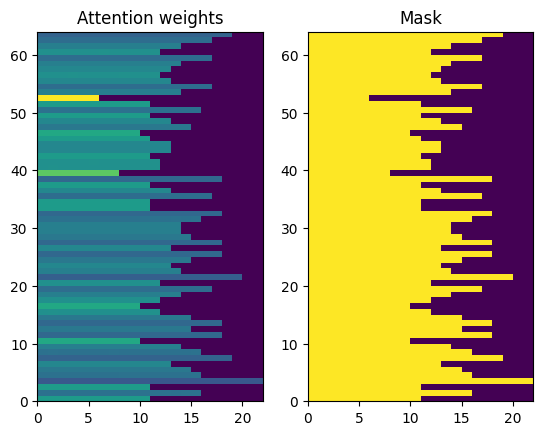

In [27]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

# The Decoder

In [28]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [29]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [30]:
decoder = Decoder(target_text_processor, UNITS)

In [31]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 22, 256)
input target tokens shape: (batch, t) (64, 65)
logits shape shape: (batch, target_vocabulary_size) (64, 65, 5000)


In [33]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 

  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

  return next_token, done, state

In [34]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'ams should jurors register refining wages interests epidemiology understand before',
       b'minute discrimination mentored housing awards college could excess digital requests',
       b'equal larger equality tentative signup geology debate war force off'],
      dtype=object)

# Training

In [35]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [37]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 22)
Target tokens, shape: (batch, t) (64, 65)
logits, shape: (batch, t, target_vocabulary_size) (64, 65, 5000)


In [38]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [39]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [40]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [41]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [42]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 31s 1s/step - loss: 8.5295 - masked_acc: 3.0414e-05 - masked_loss: 8.5295


{'loss': 8.529455184936523,
 'masked_acc': 3.0413624699576758e-05,
 'masked_loss': 8.529455184936523}

In [43]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)
    ]
)

Epoch 1/100
 10/100 [==>...........................] - ETA: 3:27 - loss: 7.4177 - masked_acc: 0.0627 - masked_loss: 7.4177

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

# Now using the thing

In [ ]:
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)

    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [44]:
result = model.translate(['¿Todavía está en casa?']) # Are you still home
result[0].numpy().decode()

AttributeError: 'Translator' object has no attribute 'translate'

In [45]:
model.plot_attention('¿Todavía está en casa?') # Are you still home

AttributeError: 'Translator' object has no attribute 'plot_attention'

In [ ]:
%%time
# This is my life.
model.plot_attention('Esta es mi vida.')

# Exporting the model

In [46]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [47]:
export = Export(model)

In [48]:
%%time
_ = export.translate(tf.constant(inputs))

NameError: name 'inputs' is not defined

In [49]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

NameError: name 'inputs' is not defined

In [50]:
%%time
tf.saved_model.save(export, 'translator',
                    signatures={'serving_default': export.translate})

AttributeError: in user code:

    File "/tmp/ipykernel_28155/1255225850.py", line 7, in translate  *
        return self.model.translate(inputs)

    AttributeError: 'Translator' object has no attribute 'translate'


In [ ]:
%%time
reloaded = tf.saved_model.load('translator')
_ = reloaded.translate(tf.constant(inputs)) #warmup